# MDpT trainings

**Goal:** I just finished some of the trainings for some of promising hyperparameters for the 2016 dataset, and I'm curious if I'll see more stable prediction with this cut??

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import combinations
from glob import glob
from time import time

import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.stats import pearsonr

from plotUtils import significance

import os
os.sys.path.append('../GraphNN/')
from preprocess import MDpT_cut,MDR_cut

os.sys.path.append('../Flow-Models/')
from densityEstimate import *
from densityPlots import *

os.sys.path.append('../code')
from eventDisplays import rainbow_text


# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
subDir = 'data16_PFlow-FEB20-5jets'
tag = '_SM_2b_p_0.01'
seedTag = ''
prodTag = 'FEB20'
ntag = 2

cols = ['log_pT_h1','log_pT_h2','eta_h1','eta_h2','log_dphi_hh']
s = f'm_h1>{126-45} & m_h1<{126+45} & m_h2>{116-45} & m_h2<{116+45}'
d_orig = data(5, 16, prodTag, tag, ntag, s)

mask = (d_orig.df.abs_deta_hh < 1.5) 
d_orig.mlPrepare(mask,cols,N=-1)

mask = mask & d_orig.df.MDpT
d_mdpt = data(5, 16, prodTag, tag, ntag, s)
d_mdpt.mlPrepare(mask,cols,N=-1)

../data/data16_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5
Taking 52080 events from 52080 available for the training / validation set
../data/data16_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5
Taking 50826 events from 50826 available for the training / validation set


In [3]:
# m = (df.abs_deta_hh < 1.5) & (df.kinematic_region==0)
# plt.hist(df.loc[m,'absCosThetaStar'],50,(0,1),histtype='step',color='C4',lw=1.5,label='$|\Delta \eta_{hh}|<1.5$')
# m = m & df.MDpT
# plt.hist(df.loc[m,'absCosThetaStar'],50,(0,1),histtype='step',color='C3',lw=1.5,label='$|\Delta \eta_{hh}|<1.5$ and MDpT')

# m = m & df.MDR
# plt.hist(df.loc[m,'absCosThetaStar'],50,(0,1),histtype='step',color='C2',lw=1.5,label='$|\Delta \eta_{hh}|<1.5$ and MDpT')



# plt.xlabel('$|\cos \Theta^*|$')
# plt.ylabel('Entries')
# plt.legend(loc='lower left')
# plt.title('2b SR',loc='left')
# plt.xlim(0,1)
# plt.show()

Since I used the same hps for MDpT as I had trained w/o MDpT, I should be able to let a hps dictionary just to be 2x the length as the number of MDpT files (or - I think this is how this works!!)

In [4]:
colTag = '_'.join(cols)
wildFile  = f'../Flow-Models/models/{subDir}{tag}_{ntag}b_detaCut_MDpT/'
wildFile += f'nsf_rq-coupling_{colTag}_lu_*_layers_H_*_?_blocks_K_?_B_3_lr_*_p*_iter*[!data161718]'

len(glob(wildFile))

5

In [5]:
for modelDir in glob(wildFile):
    print(modelDir)

../Flow-Models/models/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut_MDpT/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0
../Flow-Models/models/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut_MDpT/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_64_2_blocks_K_4_B_3_lr_0.0003_0.0001_p0.1_iter0
../Flow-Models/models/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut_MDpT/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_2_blocks_K_4_B_3_lr_0.001_0.001_p0.1_iter0
../Flow-Models/models/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut_MDpT/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_64_2_blocks_K_4_B_3_lr_0.001_1e-05_p0.1_iter0
../Flow-Models/models/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut_MDpT/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_5_layers_H_16_2_blocks_K_4_B_3_lr_0.0005_1e-05_p0.2_iter0


In [6]:
nSeeds = 25
nPreds = 10

In [7]:
hpCols = ['L','H','num_blocks','K','lr','beta','p','iter','MDpT']
hpCols += [f'{m} {s}' for s in range(nSeeds) for m in ['SR','val','train'] ]

hps = pd.DataFrame(0,index=range(2*len(glob(wildFile))), columns=hpCols)
hps.tail()

L  H  num_blocks  K  lr  beta  p  iter  MDpT  SR 0  ...  train 21  SR 22  \
5  0  0           0  0   0     0  0     0     0     0  ...         0      0   
6  0  0           0  0   0     0  0     0     0     0  ...         0      0   
7  0  0           0  0   0     0  0     0     0     0  ...         0      0   
8  0  0           0  0   0     0  0     0     0     0  ...         0      0   
9  0  0           0  0   0     0  0     0     0     0  ...         0      0   

   val 22  train 22  SR 23  val 23  train 23  SR 24  val 24  train 24  
5       0         0      0       0         0      0       0         0  
6       0         0      0       0         0      0       0         0  
7       0         0      0       0         0      0       0         0  
8       0         0      0       0         0      0       0         0  
9       0         0      0       0         0      0       0         0  

[5 rows x 84 columns]

In [8]:
myVars = ['m_hh','m_hh_cor2','abs_deta_hh','absCosThetaStar',
          'pT_h1', 'pT_h2', 'eta_h1', 'eta_h2', 'dphi_hh']

bins = 50
myRanges = [(200,1200),(250,1250),(0,1.75),(0,1),
            (0,400),(0,400),(-3,3),(-3,3),(-.5,np.pi)]



In [9]:
hists = []

for i,modelDir in tqdm(enumerate(glob(wildFile))):
    
    # Parse the file name for the relevant hps for the MDpT version
    modelConfig = modelDir.split('/')[-1]
    vs = modelConfig.split('_')
    
    hps.loc[2*i:2*i+1,'L'] = int(vs[16])
    hps.loc[2*i:2*i+1,'H'] = int(vs[19])
    hps.loc[2*i:2*i+1,'num_blocks'] = int(vs[20])
    hps.loc[2*i:2*i+1,'K'] = int(vs[23])
   
    hps.loc[2*i:2*i+1,'lr'] = float(vs[27])
    hps.loc[2*i:2*i+1,'beta'] = float(vs[28]) if len(vs) == 31 else 0
    
    hps.loc[2*i:2*i+1,'p'] = float(vs[-2][1:])
    hps.loc[2*i,'iter'] = int(vs[-1][4:])

    # For the model trained w/o MDpT, sometimes there was an issue w/ the iter, 
    # so just infer it manually now
    wild2 = glob(modelDir.replace('_MDpT','')[:-1]+'*[!18]')
    assert len(wild2) == 1
    modelDir0 = wild2[0]
    iter0 = int(modelDir0.split('_')[-1][4:])
    hps.loc[2*i+1,'iter'] = iter0
    
    hps.loc[2*i,'MDpT'] = True
    hps.loc[2*i+1,'MDpT'] = False
    
    
    # Loop over the seeds and access the losses 
    for seed in range(nSeeds):
    
        seedTag = f'_seed{seed}' if seed != 10 else ''
    
        for j,md in enumerate([modelDir,modelDir0]):
    
            seedDir = os.path.join(*md.split('/')[:-1]) + seedTag
            seedDir = os.path.join(seedDir,md.split('/')[-1])

            # Open json file
            try:
                with open(os.path.join(seedDir,'loss_acc.json'), 'r') as varfile:
                    metrics = json.load(varfile)

                    hps.loc[2*i+j,f'SR {seed}'] = metrics['SR_loss'][-22]
                    hps.loc[2*i+j,f'val {seed}'] = metrics['val_loss'][-22]
                    hps.loc[2*i+j,f'train {seed}'] = metrics['train_loss'][-22]
            except json.JSONDecodeError:
                print(os.path.join(seedDir,'loss_acc.json'),'is corrupted')

                
    # After looping through the seeds - if the training for all 25 of the seeds finished, let's
    # calc the mean and std deviation and *save* the result!!!
    for md in [modelDir,modelDir0]:
        histFile = os.path.join(md,'hists1d.json')

        with open(histFile, 'r') as varfile:
            out = json.load(varfile)

        # Go from lists -> np.arrays and append to the hists
        for k in out.keys():
            out[k] = np.array(out[k])

        hists.append(out)
    


5it [00:05,  1.15s/it]


In [10]:
hps

L   H  num_blocks  K      lr      beta    p  iter   MDpT      SR 0  ...  \
0  10  32           1  4  0.0010  0.000001  0.1     0   True  5.996646  ...   
1  10  32           1  4  0.0010  0.000001  0.1     0  False  5.976670  ...   
2  10  64           2  4  0.0003  0.000100  0.1     0   True  6.346914  ...   
3  10  64           2  4  0.0003  0.000100  0.1    27  False  6.355650  ...   
4  10  32           2  4  0.0010  0.001000  0.1     0   True  5.821255  ...   
5  10  32           2  4  0.0010  0.001000  0.1    33  False  5.805872  ...   
6  10  64           2  4  0.0010  0.000010  0.1     0   True  6.501378  ...   
7  10  64           2  4  0.0010  0.000010  0.1    39  False  6.517073  ...   
8   5  16           2  4  0.0005  0.000010  0.2     0   True  5.835182  ...   
9   5  16           2  4  0.0005  0.000010  0.2    17  False  5.796878  ...   

   train 21     SR 22    val 22  train 22     SR 23    val 23  train 23  \
0  5.516319  5.998298  5.462153  5.450575  5.907817  5.546298  5.543530   
1  5.379754  5.896777  5.403813  5.400202  5.842639  5.462207  5.464567   
2  5.207816  6.263824  5.230560  5.228728  6.319596  5.248284  5.251318   
3  5.151034  6.189631  5.197124  5.197448  6.241024  5.144883  5.152364   
4  5.667833  5.821656  5.651052  5.647945  5.828508  5.658674  5.664422   
5  5.569982  5.800684  5.551939  5.570509  5.798906  5.548421  5.558343   
6  5.062027  6.442670  5.013973  5.048715  6.524334  4.916868  4.990491   
7  4.899140  6.312598  5.067710  5.099999  6.376792  5.011830  5.042679   
8  5.656073  5.826630  5.622155  5.619098  5.831459  5.612438  5.620399   
9  5.548813  5.795768  5.507940  5.518594  5.806015  5.534330  5.551911   

      SR 24    val 24  train 24  
0  5.898477  5.572357  5.571030  
1  5.866276  5.472887  5.478733  
2  6.258624  5.278835  5.270538  
3  6.318463  5.073247  5.070196  
4  5.831037  5.666795  5.667471  
5  5.798225  5.556111  5.569275  
6  6.560549  4.993572  5.027041  
7  6.391579  4.986198  5.018355  
8  5.834742  5.631527  5.634089  
9  5.805355  5.519871  5.531572  

[10 rows x 84 columns]

In [11]:
ms = ['SR', 'val', 'train']

means = {}
stds  = {}

for m in ms:
    
    vals = hps[[f'{m} {s}' for s in range(nSeeds)]]
    
    means[m] = np.mean(vals, axis=1)
    stds[m]  = np.std( vals, axis=1)

In [12]:
betaStr = r'$\beta$'
xlabels = []

for i, (L,H,nb,K,lr,beta,p) in hps[['L','H','num_blocks','K','lr','beta','p']].iterrows():

    xl = f'L={L:.0f}, H={H:.0f}, {nb:.0f} blocks, K={K:.0f}, lr={lr:.0e}, {betaStr}={beta:.0e}, p={p}'
    xlabels.append(xl)

In [13]:
text = "$\mathbf{ATLAS}$ data Internal\n"
text += "2016 data FEB2020 MNT prod\n"
text += "DL1r 77% WP, $\mathrm{\mathbb{P}}_{SM},|\Delta \eta_{hh}|$ < 1.5"

In [14]:
figDir = f'figures/{subDir}{tag}_2b_detaCut_MDpT/nsf_rq-coupling_{colTag}_lu_hpScan'
figDir

'figures/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut_MDpT/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_hpScan'

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


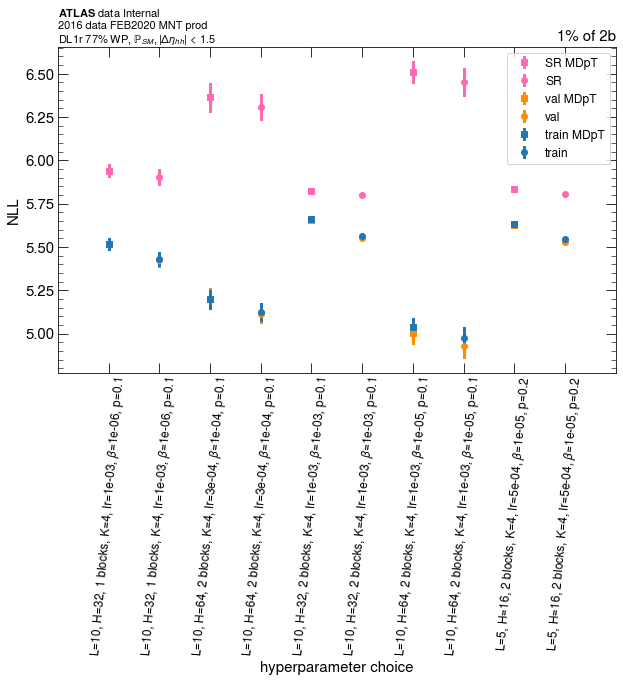

In [15]:
plt.figure(figsize=(10,6))

for mi,c in zip(ms,['hotpink','darkorange','C0']):

    plt.errorbar(hps.index[::2],means[mi][::2],stds[mi][::2],fmt='s',color=c,label=mi+' MDpT')
    plt.errorbar(hps.index[1::2],means[mi][1::2],stds[mi][1::2],fmt='o',color=c,label=mi)
    
    
plt.xticks(hps.index,xlabels,rotation=85,fontsize=12)
plt.xlabel('hyperparameter choice')
plt.ylabel('NLL')

# ymin,ymax = plt.ylim()
# plt.ylim(ymin,1.1*ymax)

plt.legend(fontsize=12,frameon=True,loc='upper right')
plt.title('1% of 2b',fontsize=15,loc='right')

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=11)
ax.tick_params(axis='x',which='minor', length=0)

plt.xlim(-1,len(hps.index))

plt.savefig(f'{figDir}/loss_configs.pdf',bbox_inches='tight')
plt.show()

In [16]:
np.argmin(means['SR'][1::2])

2

Ok - in terms of losses they're hella similar haha.

### Calculate the $\chi^2$s

In [17]:
chi2 = {c: [] for c in myVars}

m = (d_orig.df.abs_deta_hh<1.5) & (d_orig.df.kinematic_region==0)

for i,hd in enumerate(hists):

    for c,r in zip(myVars,myRanges):

        # Get the 2b contribution
        if i % 2 ==0: # MDpT
            n_2b = np.histogram(d_mdpt.df.loc[mask&m,c],bins,r)[0]

        else:
            n_2b = np.histogram(d_orig.df.loc[m, c],bins,r)[0]

        #print(chisquare(n_2b,hd[f'{c}_mean'])[0])
        chi2[c].append(chisquare(n_2b,hd[f'{c}_mean'])[0])
        
#         plt.figure()
#         e = np.linspace(*r,bins+1)
#         xx = 0.5*(e[:-1]+e[1:])
#         plt.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',label='2b')
#         plt.errorbar(xx,hd[f'{c}_mean'],hd[f'{c}_std'],fmt='.',label='pred')
#         plt.title(f'i = {i}')

#         ax = plt.gca()
#         plt.text(.8,.8,f'$\chi^2$ = {chi2[c][-1]:.1f}',ha='right',va='top',transform=ax.transAxes)
#         plt.xlabel(c)
#         plt.ylabel('Entries')



In [18]:
np.sum(n_2b)

10041

In [19]:
np.sum(hd[f'{c}_mean'])

10035.844

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


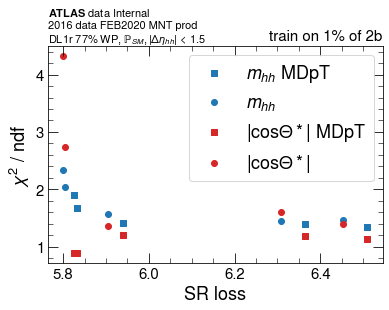

Substituting with a symbol from Computer Modern.


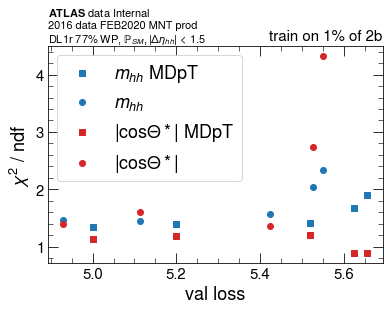

Substituting with a symbol from Computer Modern.


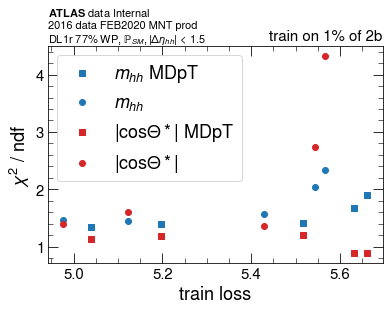

In [20]:
for mi in ['SR','val','train']:

    plt.figure()
    for c,color,l in zip(['m_hh','absCosThetaStar'],['C0','C3'],['$m_{hh}$','$|\cos\Theta *|$']):
        plt.scatter(means[mi][::2],np.array(chi2[c][::2])/bins,color=color,marker='s',label=l+' MDpT')
        plt.scatter(means[mi][1::2],np.array(chi2[c][1::2])/bins,color=color,marker='o',label=l)

    plt.xlabel(f'{mi} loss',fontsize=18)
    plt.ylabel('$\chi^2$ / ndf',fontsize=18)
    plt.legend(frameon=True,fontsize=18)


    ax = plt.gca()
    plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=11)

    plt.title('train on 1% of 2b',fontsize=15,loc='right')

    plt.savefig(f'{figDir}/chi2ndf_m_hh_absCosThetaStar_vs_{mi}_loss.pdf',bbox_inches='tight')


In [21]:
corr_mat = np.ones(tuple([len(myVars)]*2))
corr_mat0 = np.ones(tuple([len(myVars)]*2))

for i,ci in enumerate(myVars):
    for j,cj in zip(range(i+1,len(myVars)),myVars[i+1:]):

        Rij = pearsonr(np.array(chi2[ci][::2]),np.array(chi2[cj][::2]))[0]
        corr_mat[i,j] = Rij
        corr_mat[j,i] = Rij
        
        
        Rij = pearsonr(np.array(chi2[ci][1::2]),np.array(chi2[cj][1::2]))[0]
        corr_mat0[i,j] = Rij
        corr_mat0[j,i] = Rij

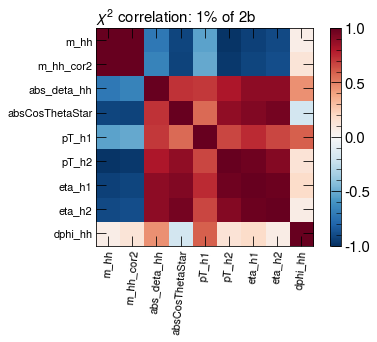

In [22]:
plt.imshow(corr_mat,cmap='RdBu_r',vmin=-1,vmax=1)

plt.colorbar()
plt.title('$\chi^2$ correlation: 1% of 2b',fontsize=15,loc='left')

# Label based on variable names
plt.xticks(range(len(myVars)),myVars,rotation=85,fontsize=11)
plt.yticks(range(len(myVars)),myVars,fontsize=11)

# Remove minor ticks
ax = plt.gca()
ax.tick_params(which='minor', length=0)

#plt.savefig(f'{figDir}/chi2_correlation_allVars.pdf',bbox_inches='tight')

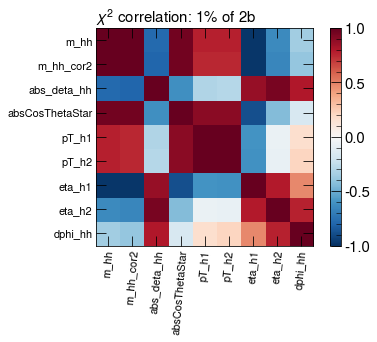

In [23]:
plt.imshow(corr_mat0,cmap='RdBu_r',vmin=-1,vmax=1)

plt.colorbar()
plt.title('$\chi^2$ correlation: 1% of 2b',fontsize=15,loc='left')

# Label based on variable names
plt.xticks(range(len(myVars)),myVars,rotation=85,fontsize=11)
plt.yticks(range(len(myVars)),myVars,fontsize=11)

# Remove minor ticks
ax = plt.gca()
ax.tick_params(which='minor', length=0)

#plt.savefig(f'{figDir}/chi2_correlation_allVars.pdf',bbox_inches='tight')

In [24]:
corr_mat-corr_mat0

array([[ 0.00000000e+00, -9.71044196e-04,  6.88863524e-02,
        -1.88861622e+00, -1.31347280e+00, -1.75226173e+00,
         3.63688284e-02, -2.59910455e-01,  4.16112601e-01],
       [-9.71044196e-04,  0.00000000e+00,  1.25948364e-01,
        -1.88769506e+00, -1.26535414e+00, -1.71432584e+00,
         5.84673394e-02, -2.35011182e-01,  5.16940279e-01],
       [ 6.88863524e-02,  1.25948364e-01,  0.00000000e+00,
         1.33611132e+00,  1.00644458e+00,  1.09053358e+00,
         2.33565320e-02, -5.63701507e-02, -3.44907110e-01],
       [-1.88861622e+00, -1.88769506e+00,  1.33611132e+00,
         0.00000000e+00, -3.39167025e-01, -1.42979458e-02,
         1.80503735e+00,  1.38713555e+00, -2.54833083e-02],
       [-1.31347280e+00, -1.26535414e+00,  1.00644458e+00,
        -3.39167025e-01,  0.00000000e+00, -3.27584528e-01,
         1.34543700e+00,  7.31568731e-01,  4.35305359e-01],
       [-1.75226173e+00, -1.71432584e+00,  1.09053358e+00,
        -1.42979458e-02, -3.27584528e-01,  0.000000

Yeah - I'm not sure how to interpret this.

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


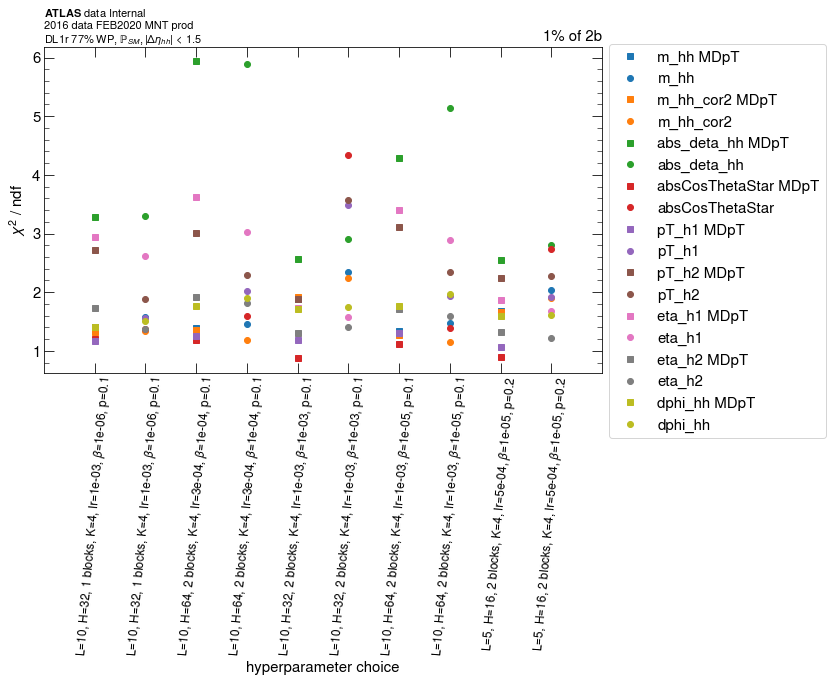

In [25]:
plt.figure(figsize=(10,6))

for i,c in enumerate(myVars):

    plt.errorbar(hps.index[::2],np.array(chi2[c][::2])/bins,label=c+' MDpT',fmt='s',color=f'C{i}')
    plt.errorbar(hps.index[1::2],np.array(chi2[c][1::2])/bins,label=c,fmt='o',color=f'C{i}')
    
plt.xticks(hps.index,xlabels,rotation=85,fontsize=12)
plt.xlabel('hyperparameter choice')
plt.ylabel(f'$\chi^2$ / ndf')

plt.legend(fontsize=15,frameon=True,bbox_to_anchor=(1,1.03))
plt.title('1% of 2b',fontsize=15,loc='right')

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=11)
ax.tick_params(axis='x',which='minor', length=0)

plt.xlim(-1,len(hps.index))

plt.savefig(f'{figDir}/chi2ndf_allVars.pdf',bbox_inches='tight')
plt.show()

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


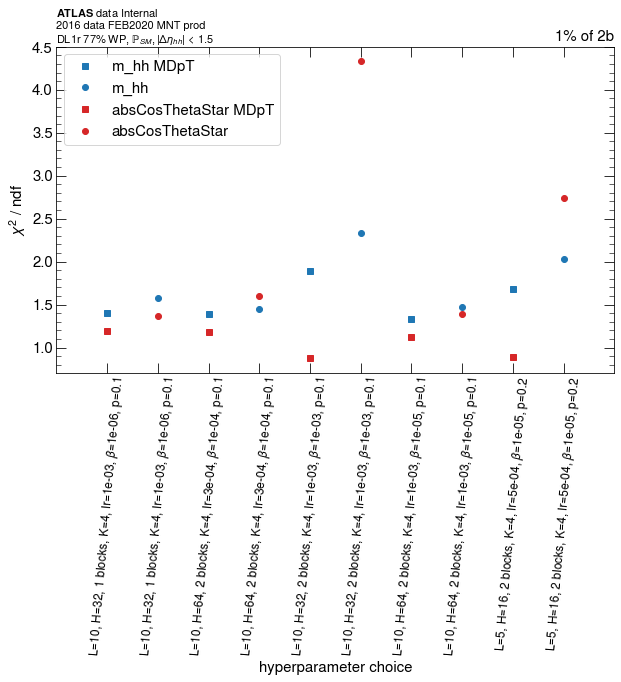

In [26]:
plt.figure(figsize=(10,6))

for i,c in zip([0,3],['m_hh','absCosThetaStar']):

    plt.errorbar(hps.index[::2],np.array(chi2[c][::2])/bins,label=c+' MDpT',fmt='s',color=f'C{i}')
    plt.errorbar(hps.index[1::2],np.array(chi2[c][1::2])/bins,label=c,fmt='o',color=f'C{i}')
    
plt.xticks(hps.index,xlabels,rotation=85,fontsize=12)
plt.xlabel('hyperparameter choice')
plt.ylabel(f'$\chi^2$ / ndf')

plt.legend(fontsize=15,frameon=True)
plt.title('1% of 2b',fontsize=15,loc='right')

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=11)
ax.tick_params(axis='x',which='minor', length=0)

plt.xlim(-1,len(hps.index))

plt.savefig(f'{figDir}/chi2ndf_m_hh_absCosThetaStar.pdf',bbox_inches='tight')
plt.show()

In [27]:
np.argmin(chi2['m_hh'])

6

In [28]:
np.argmin(chi2['absCosThetaStar'])

4

In [29]:
np.argmin(np.array(chi2['m_hh'])**2+np.array(chi2['absCosThetaStar'])**2)

6

## Let's compare the variable modelling


At first I tried just comparing everything at once, but this was *way* too unwieldy (too many lines on a curve) so instead I made separate subdirectories that I put individual modelling plots in.


In [30]:
varLabels = ['$m_{hh}$ [GeV]','$m_{hh}^{cor,2}$ [GeV]',
             '$|\Delta \eta_{hh}|$','$|\cos \Theta *|$',
             '$p_T^{h1}$','$p_T^{h2}$','$\eta_{h1}$','$\eta_{h2}$','$\Delta \Phi_{hh}$']

In [31]:
colors_mdpt = ['darkred','red','orange']
colors_orig = ['navy','dodgerblue','lime']

In [32]:
mpl.rcParams['figure.max_open_warning'] = 0

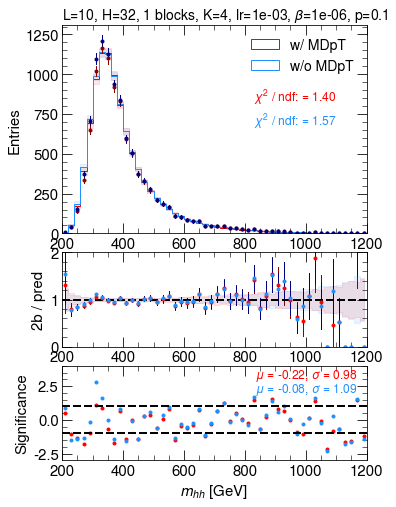

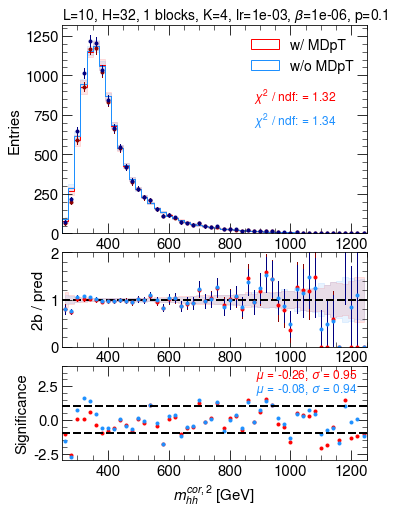

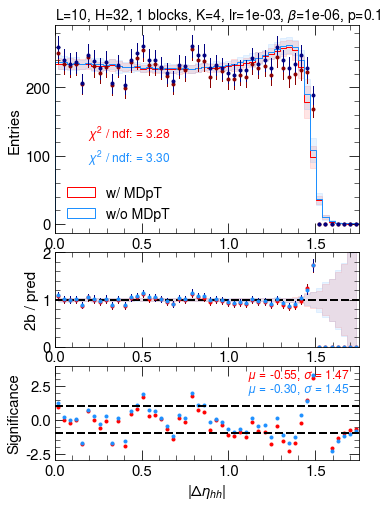

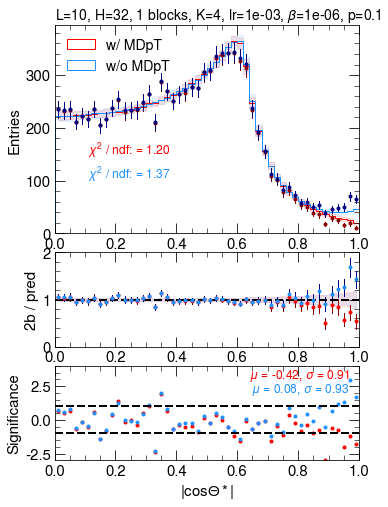

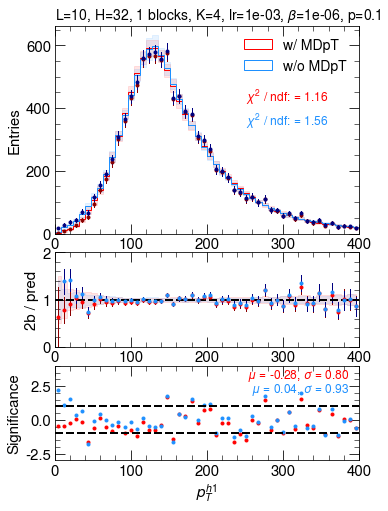

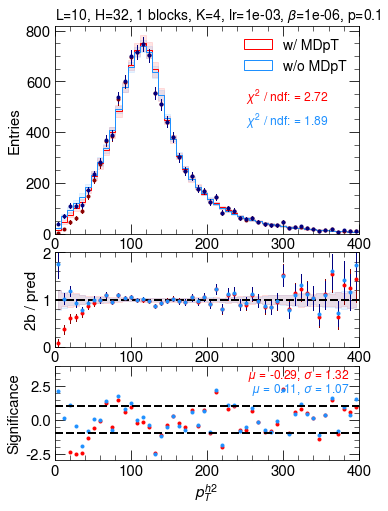

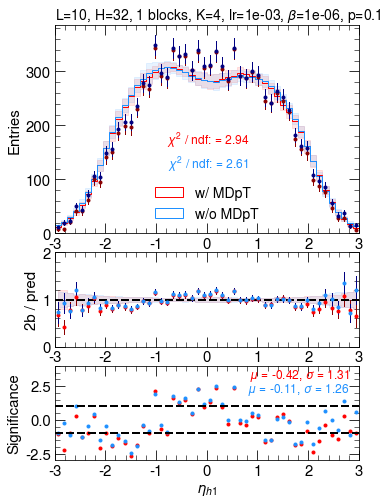

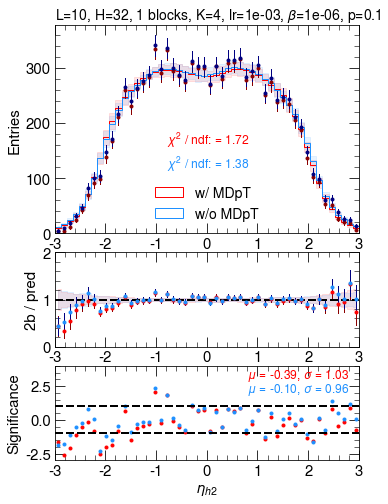

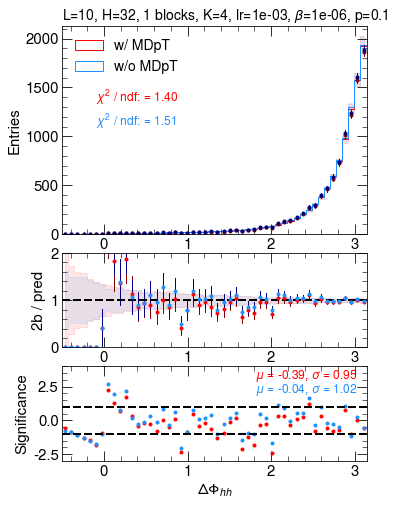

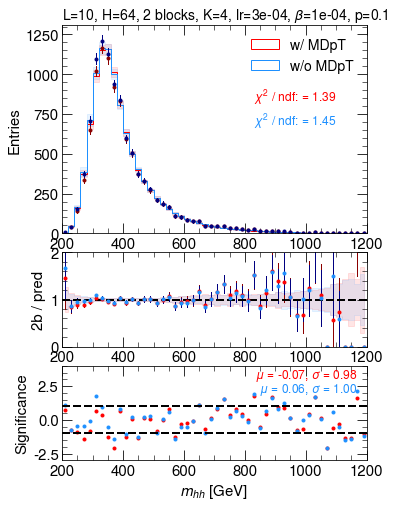

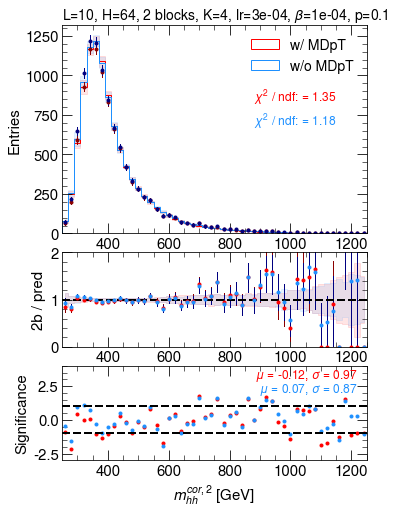

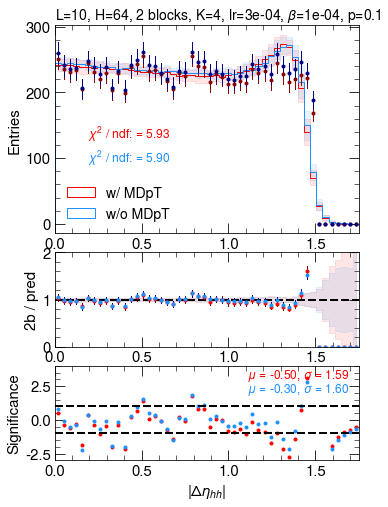

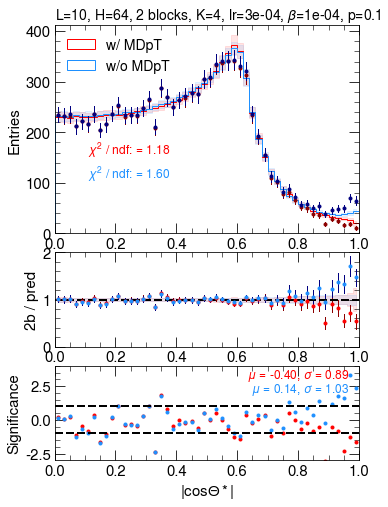

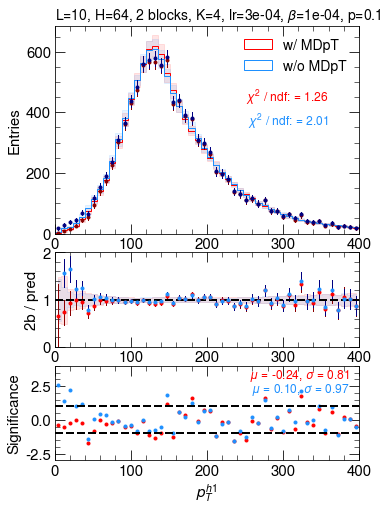

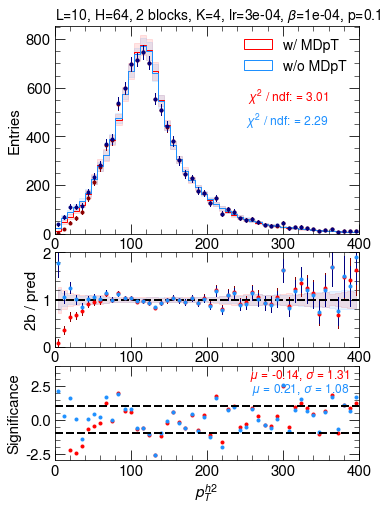

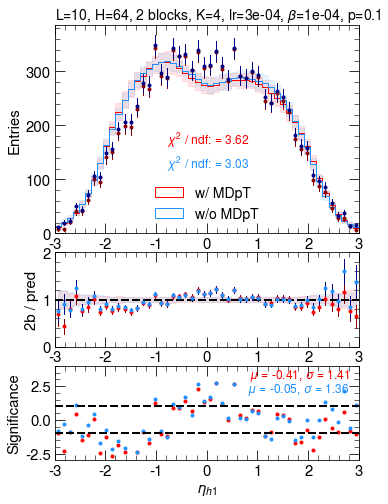

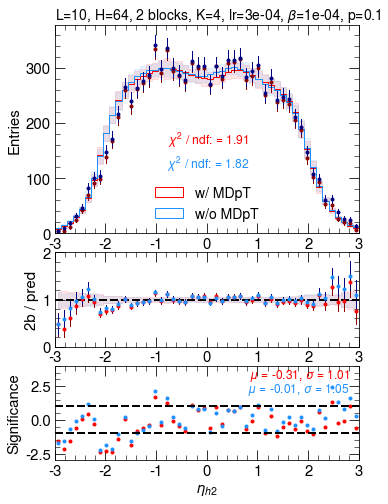

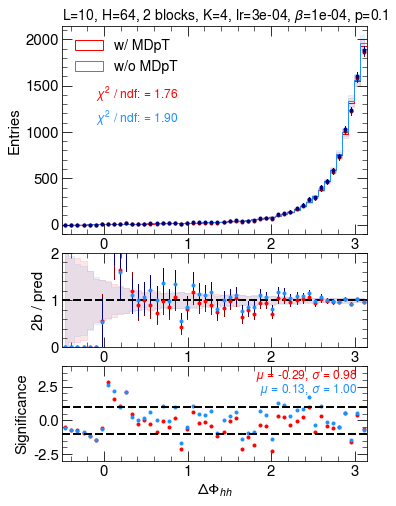

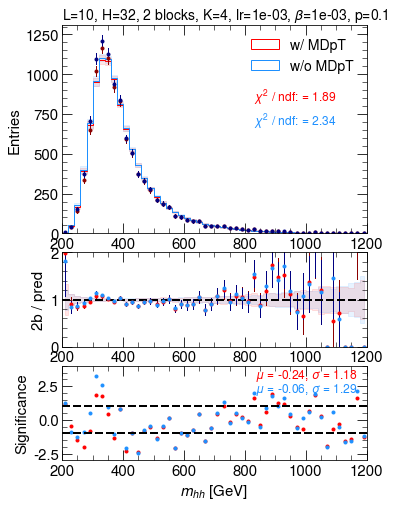

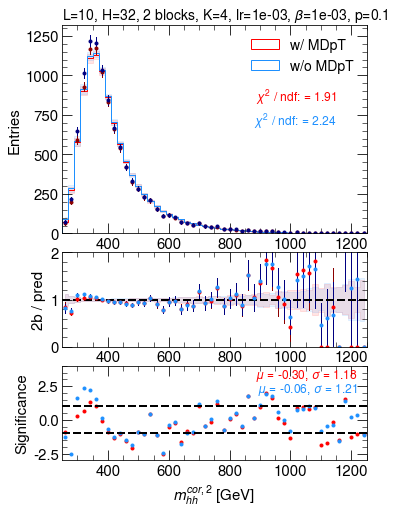

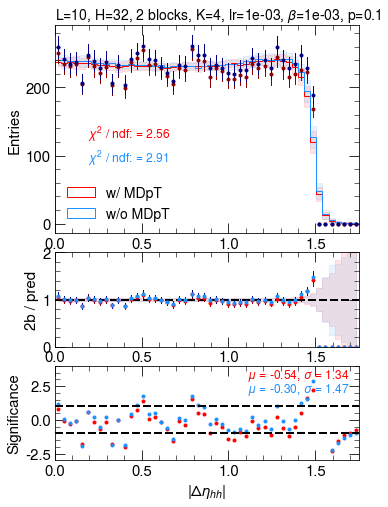

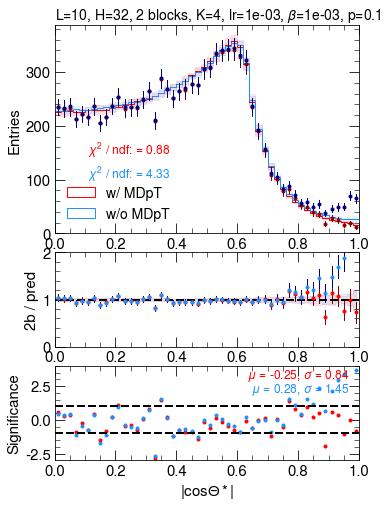

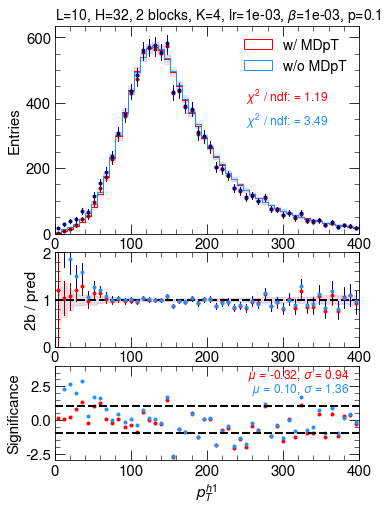

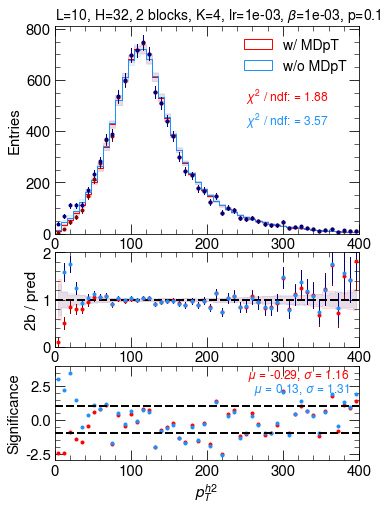

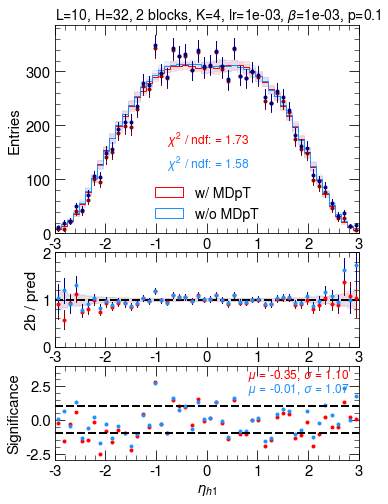

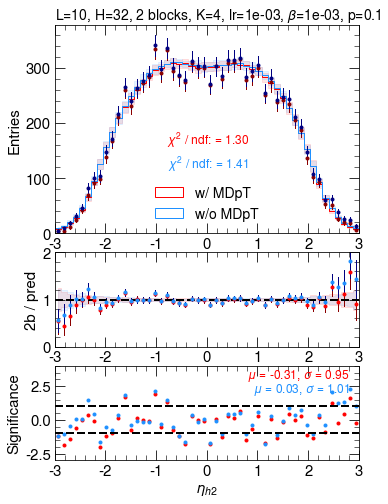

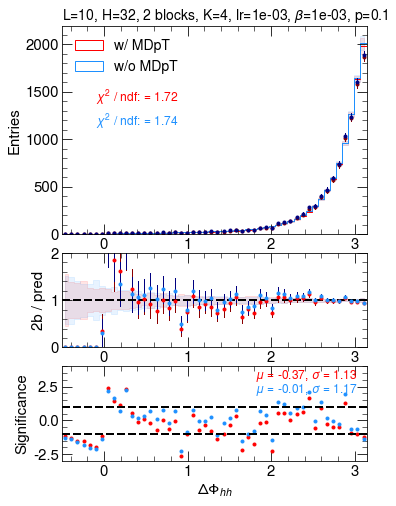

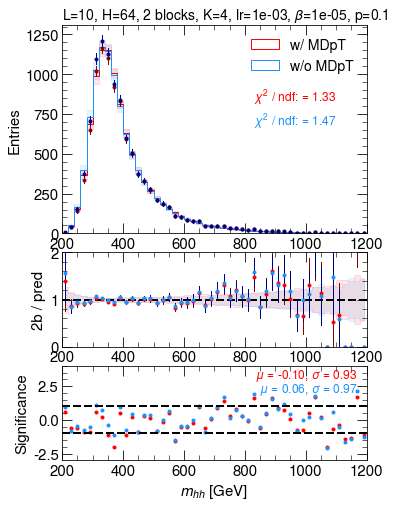

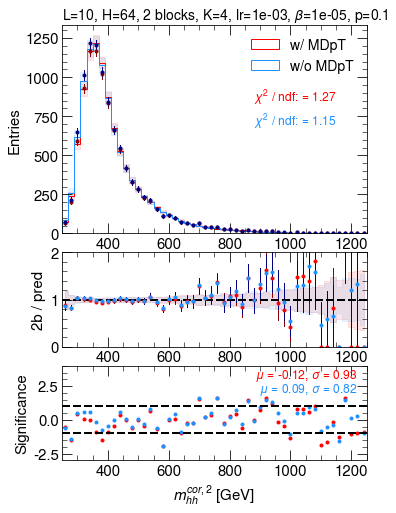

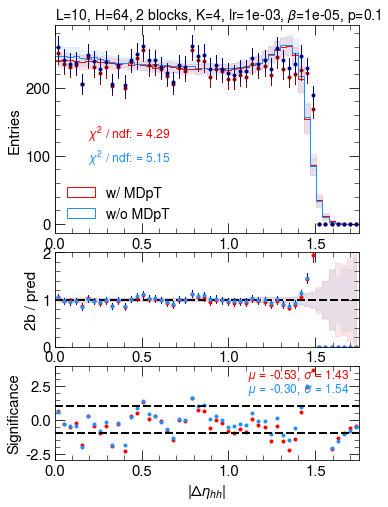

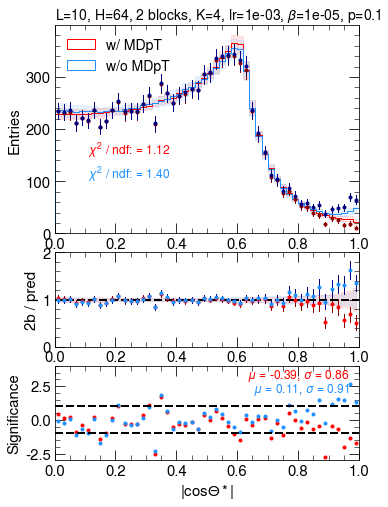

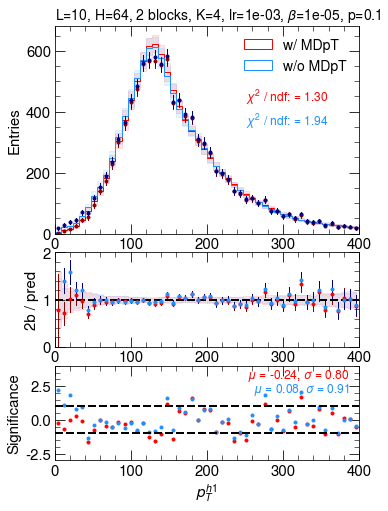

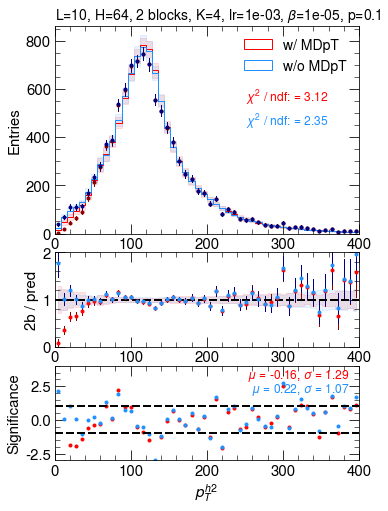

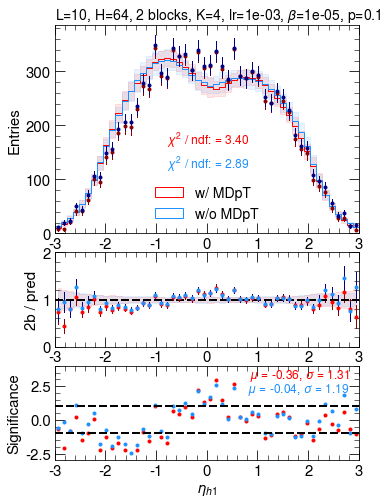

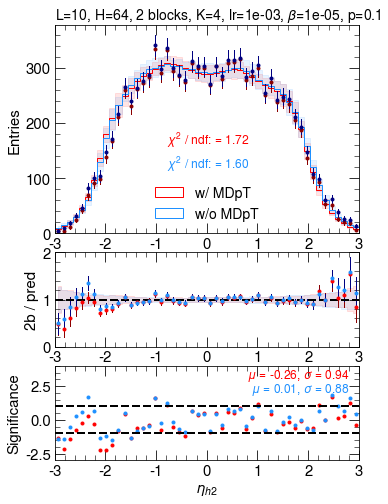

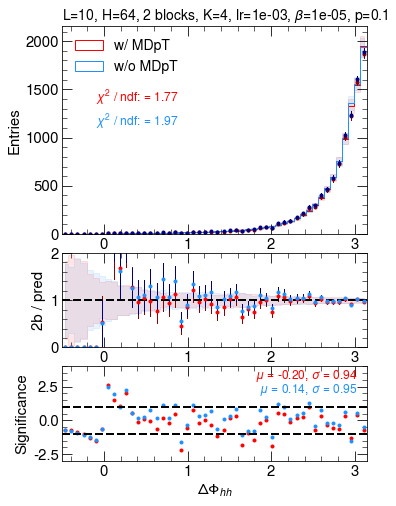

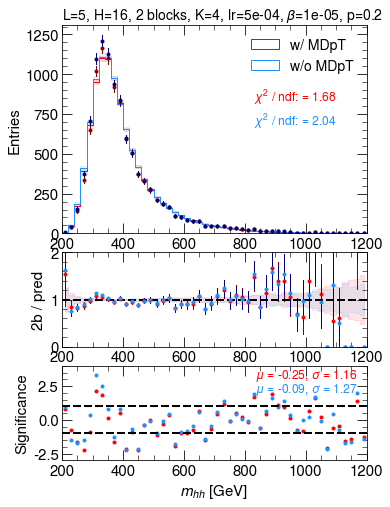

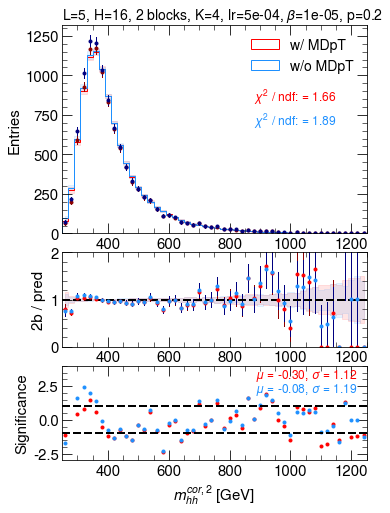

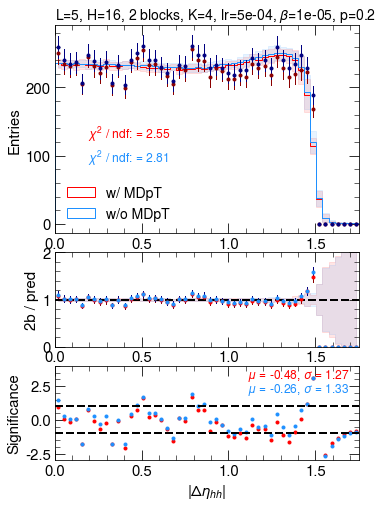

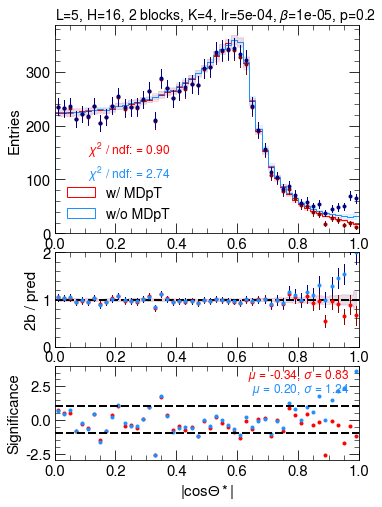

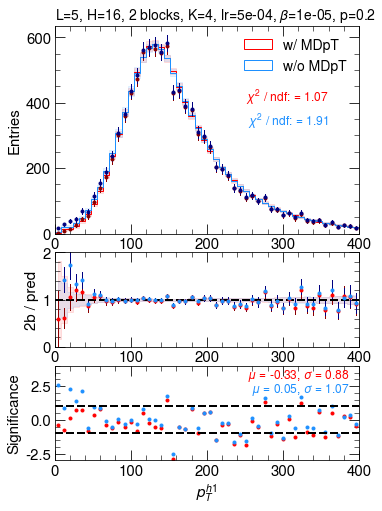

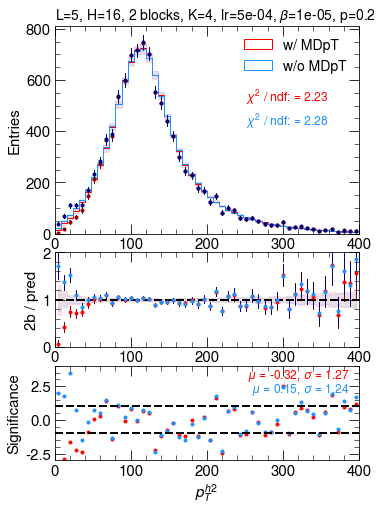

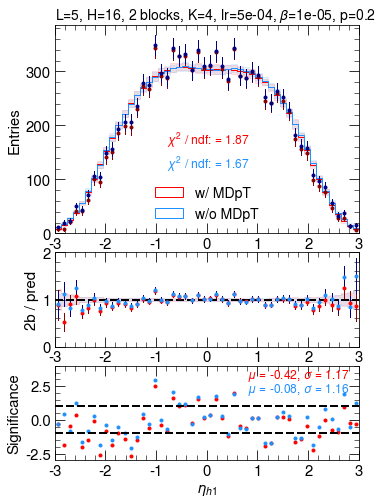

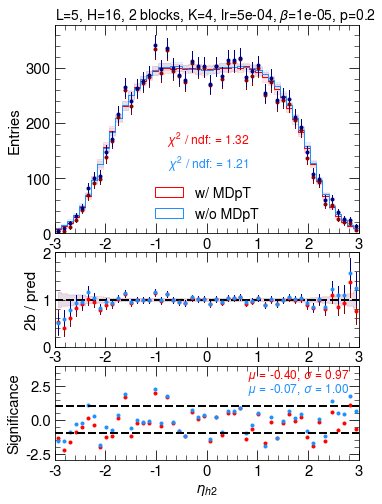

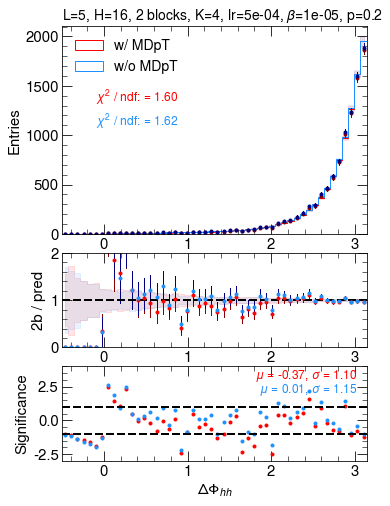

In [33]:
for i in range(5):
    
    for c,r,xl,wx,wy,ha,va in zip(myVars, myRanges,varLabels,
                                  [0.9,0.9,0.1,0.1,0.9,0.9,0.5,0.5,0.1],
                                  [0.7,0.7,0.4,0.35,0.7,0.7,0.4,0.4,0.7],
                                  ['right','right','left','left','right','right','center','center','left'],
                                  ['top','top','bottom','bottom','top','top','bottom','bottom','top']):

        # Make the figure
        fig = plt.figure(figsize=(12,8))
        gs = gridspec.GridSpec(4,2)
        ax1 = fig.add_subplot(gs[:2,0])
        ax2 = fig.add_subplot(gs[2,0],sharex=ax1)
        ax3 = fig.add_subplot(gs[3,0],sharex=ax1)

        n_2b,e  = np.histogram(d_mdpt.df.loc[mask&m,c],bins,r)
        n_2b0,e = np.histogram(d_orig.df.loc[m,c],bins,r)
        xx = 0.5 * ( e[1:] + e[:-1] )

        # Add text for the chi^2s for these comparisons
        ls,lc = [], []
        zs,zc = [], []

        for j,color,l,ni,k in zip([0,1],['red','dodgerblue'],['w/ MDpT','w/o MDpT'],[n_2b,n_2b0],['darkred','navy']):
            
            nom = hists[2*i+j][f'{c}_mean']
            std = hists[2*i+j][f'{c}_std']

            ax1.fill_between(xx, nom+std, nom-std, color=color,zorder=0,step='mid',alpha=.1)
            ax2.fill_between(xx, (nom+std)/nom, (nom-std)/nom, color=color,zorder=0,step='mid',alpha=0.1)

            ax1.hist(xx, bins,r,color=color,histtype='step',weights=nom,label=l)
            ax2.errorbar(xx,ni/nom,np.sqrt(ni)/nom,fmt='.',color=color,elinewidth=1,ecolor=k)

            ls.append(f'$\chi^2$ / ndf: = {chi2[c][2*i+j]/bins:.2f}')
            lc.append(color)

            z = significance(ni,nom,std)
            ax3.plot(xx,z,lw=0,marker='.',color=color)

            mu,sigma = np.mean(z),np.std(z)
            zs.append(f'$\mu$ = {mu:1.2f}, $\sigma$ = {sigma:1.2f}')
            zc.append(color)


        # Add some curves and lines which only needs to be done once
        ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='darkred',elinewidth=1)
        ax1.errorbar(xx,n_2b0,np.sqrt(n_2b0),fmt='.',color='navy',elinewidth=1)
        ax2.plot(r,[1]*2,'k--',lw=2)

        ax3.plot(r,[1]*2,'k--',lw=2)
        ax3.plot(r,[-1]*2,'k--',lw=2)

        # legends
        ax1.set_ylabel('Entries')
        ax2.set_ylabel('2b / pred')
        ax3.set_ylabel('Significance')
        ax3.set_xlabel(xl)

        # ranges
        ax1.set_xlim(r)
        ax2.set_ylim(0,2)
        ax3.set_ylim(-3, 4)
        ax1.legend()

        ax1.set_title(xlabels[2*i],fontsize=14,loc='left')
        
        x = wx*r[1]+ (1-wx)*r[0]
        y = wy*ax1.get_ylim()[1]
        rainbow_text(x,y,ls,lc,yoffset=1.2,ax=ax1,fontsize=12,ha=ha,va=va)
        rainbow_text(.97*r[1]+.03*r[0],3.9,zs,zc,yoffset=.9,ax=ax3,fontsize=12,ha='right',va='top')

        L, H, nb, K, lr, beta, p = hps.loc[2*i,['L','H','num_blocks','K','lr','beta','p']].values        
        tmpDir  = f'{figDir}/cf_woMDpT/L{L}_H{H}_{nb}blocks_K{K}_lr{lr}_beta{beta}_p{p}'
        
        if not os.path.exists(tmpDir):
            os.mkdir(tmpDir)
            
        plt.savefig(f'{tmpDir}/{c}_SR.pdf',bbox_inches='tight')
        

## Compare to Real NVP 

In [34]:
nSeeds,nPreds

(25, 10)

In [35]:
myVars

['m_hh',
 'm_hh_cor2',
 'abs_deta_hh',
 'absCosThetaStar',
 'pT_h1',
 'pT_h2',
 'eta_h1',
 'eta_h2',
 'dphi_hh']

In [37]:
lr = .001
L, H = 5,32
i = 0

rcols = ['log_pT_h1','log_pT_h2','eta_h2','eta_h1','log_dphi_hh']
rcolTag = '_'.join(cols)

beta = 1e-3

reload=False

In [73]:
# histogram setup
rhists = []
rhist_list = {f'{k}{t}':[] for k in myVars for t in ['','_MDpT']}

for seed in tqdm(range(250)):

    # Load in the R-NVP
    seedTag = f'_seed{seed}' if seed != 10 else ''
    ri = RealNVP(f'{subDir}{tag}_2b_detaCut{seedTag}', lr, beta, rcols, 0, L, H,
                 load_model=True,modelBaseDir='../Flow-Models/models',debug=False)
    filename = f'{ri.modelDir}/df_SR.h5'
    key = f'p_{p}_beta{beta:.0e}_seed{seed}'
    dfi = pd.read_hdf(filename,key='df')
      
    # Calc the new var we want to plot
    dfi['abs_deta_hh'] = np.abs(dfi.eta_h1-dfi.eta_h2)
    MDpT_cut(dfi)
    
    # Make histograms
    for c,r in zip(myVars,myRanges):
        rhist_list[c].append(np.histogram(dfi[c],bins,r)[0] / nPreds)
        rhist_list[f'{c}_MDpT'].append(np.histogram(dfi.loc[dfi.MDpT,c],bins,r)[0] / nPreds)

        
# After looping through the seeds -  let's
# calc the mean and std deviation and *save* the result!!!
histFile = os.path.join(ri.modelDir.replace(seedTag,''),
                        f'hists1d.json')

out = {}
for c in rhist_list.keys():
    stack = np.vstack(rhist_list[c])
    out[f'{c}_mean'] = list(np.mean(stack,axis=0))
    out[f'{c}_std']  = list(np.std( stack,axis=0))

with open(histFile, 'w') as varfile:
    json.dump(out, varfile)


100%|██████████| 250/250 [02:26<00:00,  1.71it/s]


In [74]:
for k,v in out.items():
    out[k] = np.array(v)

**Compare w/o the MDpT cuts**

In [66]:
myVars

['m_hh',
 'm_hh_cor2',
 'abs_deta_hh',
 'absCosThetaStar',
 'pT_h1',
 'pT_h2',
 'eta_h1',
 'eta_h2',
 'dphi_hh']

'figures/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_hpScan/cf_RealNVP'

figures/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_hpScan/cf_RealNVP


Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a 

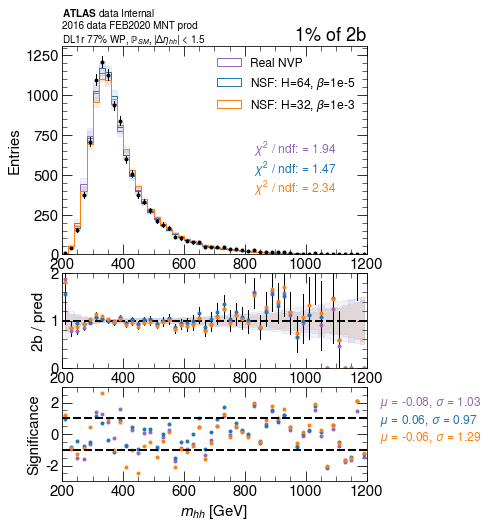

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


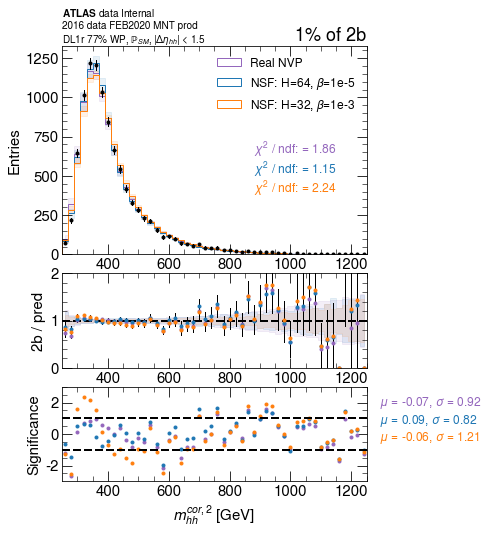

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


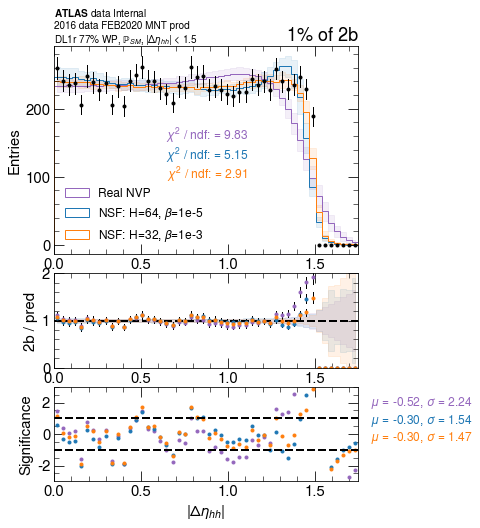

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


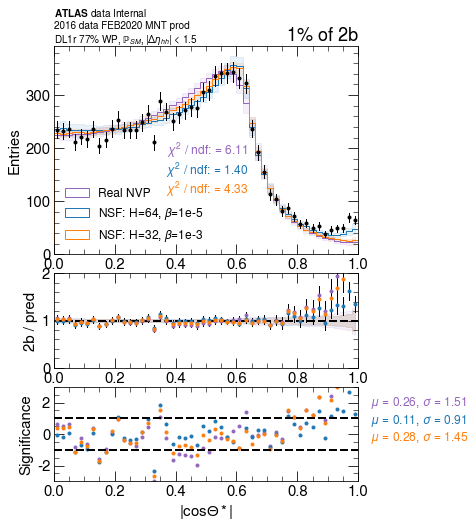

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


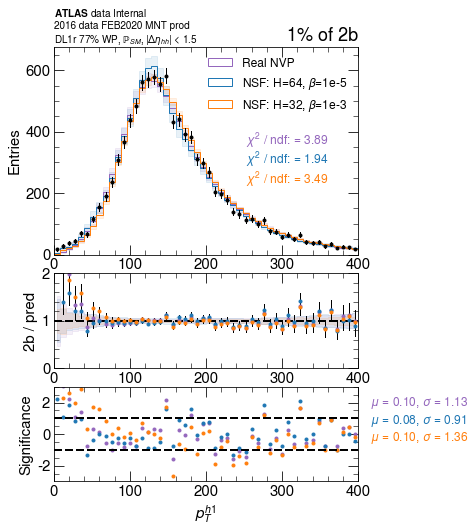

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


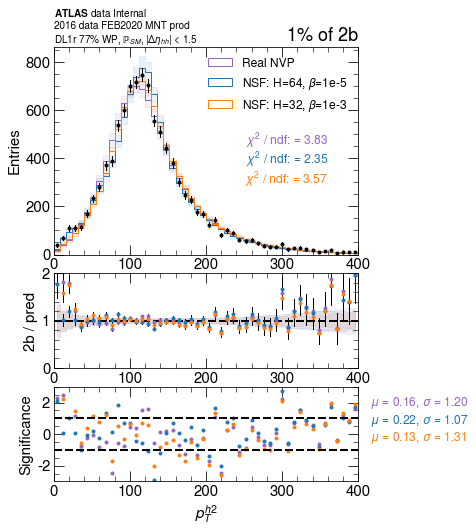

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


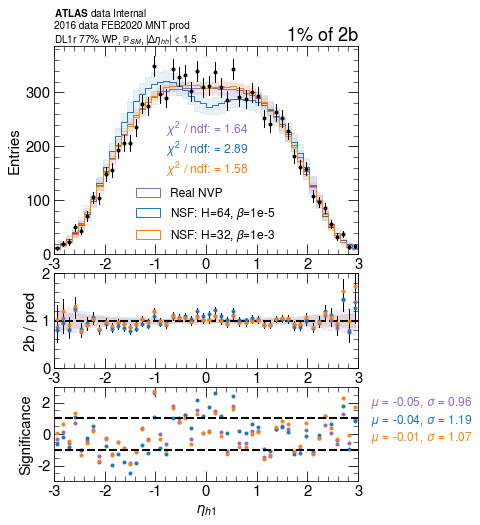

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


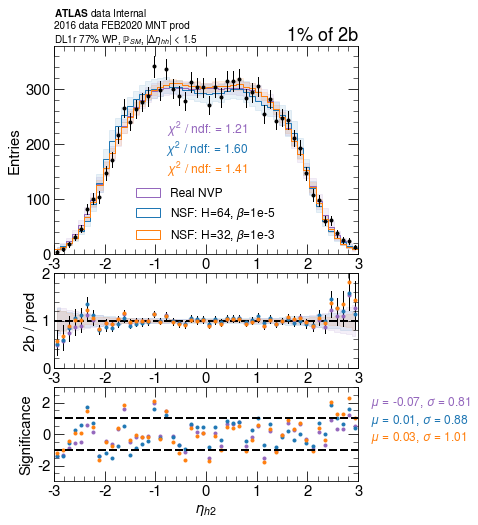

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


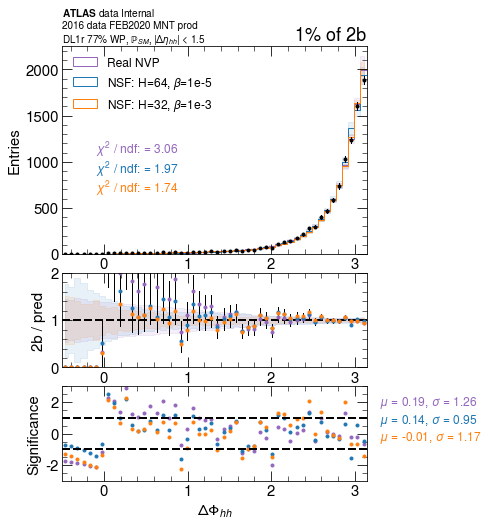

In [85]:
mask = (d_orig.df.abs_deta_hh < 1.5) & (d_orig.df.kinematic_region==0)
tmpDir = figDir.replace('_MDpT','') + '/cf_RealNVP'
print(tmpDir)

for c,r,xl,wx,wy,ha,va in zip(myVars, myRanges,varLabels,
                              [0.9, 0.9, 0.5, 0.5,0.9,0.9,0.5,0.5,0.1],
                              [0.55,0.55,0.5,0.45,0.5,0.5,0.55,0.55,0.55],
                              ['right','right','center','center','right','right','center','center','left'],
                              ['top','top','bottom','bottom','bottom','bottom','bottom','bottom','top']):

    # Make the figure
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(4,2)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = fig.add_subplot(gs[2,0],sharex=ax1)
    ax3 = fig.add_subplot(gs[3,0],sharex=ax1)
    
    n_2b,e = np.histogram(d_orig.df.loc[mask,c],bins,r)
    xx = 0.5 * ( e[1:] + e[:-1] )
    
    # Add text for the chi^2s for these comparisons
    ls,lc = [], []
    zs,zc = [], []
    
    for nom,std,color,l in zip([out[f'{c}_mean'],hists[7][f'{c}_mean'],hists[5][f'{c}_mean']],
                               [out[f'{c}_std'],hists[7][f'{c}_std'],hists[5][f'{c}_std']],
                               ['C4','C0','C1'],['Real NVP',f'NSF: H=64, {betaStr}=1e-5',f'NSF: H=32, {betaStr}=1e-3']):
        
        ax1.fill_between(xx, nom+std, nom-std, color=color,zorder=0,step='mid',alpha=.1)
        ax2.fill_between(xx, (nom+std)/nom, (nom-std)/nom, color=color,zorder=0,step='mid',alpha=0.1)
        
        ax1.hist(xx, bins,r,color=color,histtype='step',weights=nom,label=l)
        ax2.errorbar(xx,n_2b/nom,np.sqrt(n_2b)/nom,fmt='.',color=color,elinewidth=1,ecolor='k')
        
        X2 = chisquare(n_2b,nom)[0]
        ls.append(f'$\chi^2$ / ndf: = {X2/bins:.2f}')
        lc.append(color)
        
        z = significance(n_2b,nom,std)
        ax3.plot(xx,z,lw=0,marker='.',color=color)
        
        mu,sigma = np.mean(z),np.std(z)
        zs.append(f'$\mu$ = {mu:1.2f}, $\sigma$ = {sigma:1.2f}')
        zc.append(color)
        
    
    # Add some curves and lines which only needs to be done once
    ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',elinewidth=1)
    ax2.plot(r,[1]*2,'k--',lw=2)
    
    ax3.plot(r,[1]*2,'k--',lw=2)
    ax3.plot(r,[-1]*2,'k--',lw=2)
    
    # legends
    ax1.set_ylabel('Entries')
    ax2.set_ylabel('2b / pred')
    ax3.set_ylabel('Significance')
    ax3.set_xlabel(xl)
    
    # ranges
    ax1.set_xlim(r)
    ax2.set_ylim(0,2)
    ax3.set_ylim(-3, 3)
    ax1.legend(fontsize=12)
    
    ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes,fontsize=10)
    ax1.set_title('1% of 2b',loc='right')
    
    x = wx*r[1]+ (1-wx)*r[0]
    y = wy*ax1.get_ylim()[1]
    rainbow_text(x,y,ls,lc,yoffset=1,ax=ax1,fontsize=12,ha=ha,va=va)
    rainbow_text(1.03*r[1]+-.03*r[0],2.5,zs,zc,yoffset=1.1,ax=ax3,fontsize=12,ha='left',va='top')
    
    plt.savefig(f'{tmpDir}/{c}_SR_L_10_2_blocks_K_4_lr_0.001_p_0.01.pdf',bbox_inches='tight')
    #break

In [63]:
hps.iloc[7]

L                  10
H                  64
num_blocks          2
K                   4
lr              0.001
               ...   
val 23        5.01183
train 23      5.04268
SR 24         6.39158
val 24         4.9862
train 24      5.01836
Name: 7, Length: 84, dtype: object

In [64]:
hps.iloc[5]

L                  10
H                  32
num_blocks          2
K                   4
lr              0.001
               ...   
val 23        5.54842
train 23      5.55834
SR 24         5.79823
val 24        5.55611
train 24      5.56927
Name: 5, Length: 84, dtype: object

**Compare with the MDpT cuts**

Although the caveat here is the RealNVP eval *after* the cut and training *with* the cut, and the NSF has the cut both for training and inference.

In [78]:
mask = (d_mdpt.df.abs_deta_hh < 1.5) & (d_mdpt.df.kinematic_region==0) & d_mdpt.df.MDpT
tmpDir = figDir + '/cf_RealNVP'

if not os.path.exists(tmpDir):
    os.mkdir(tmpDir)

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a 

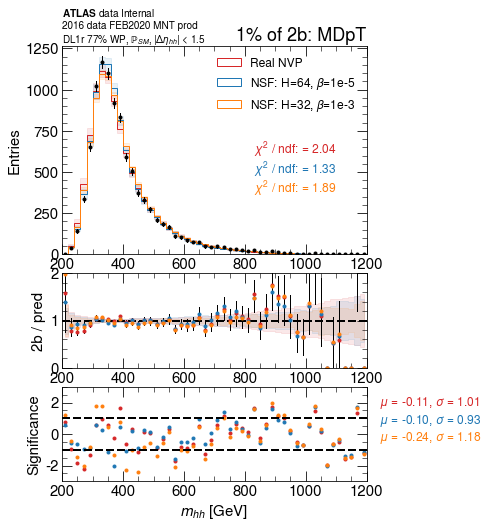

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


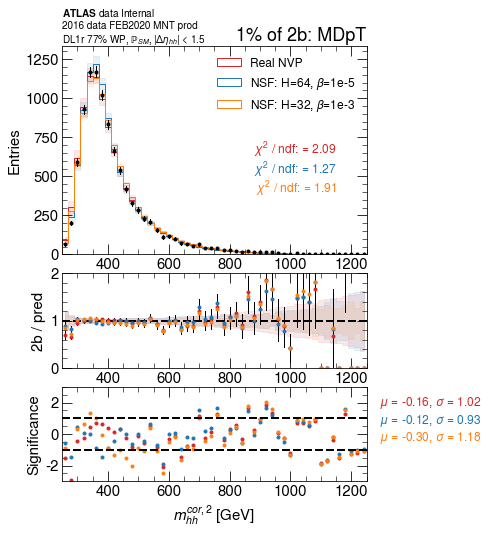

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


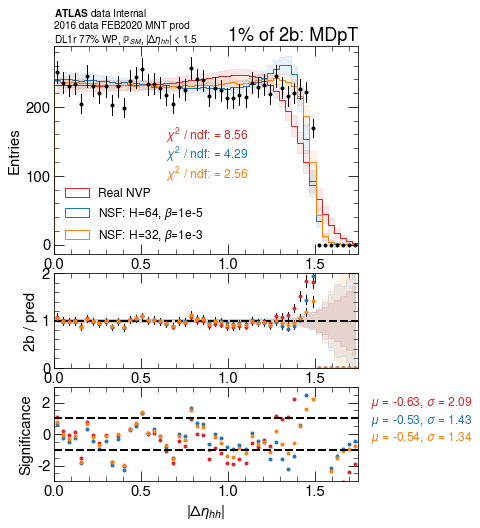

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


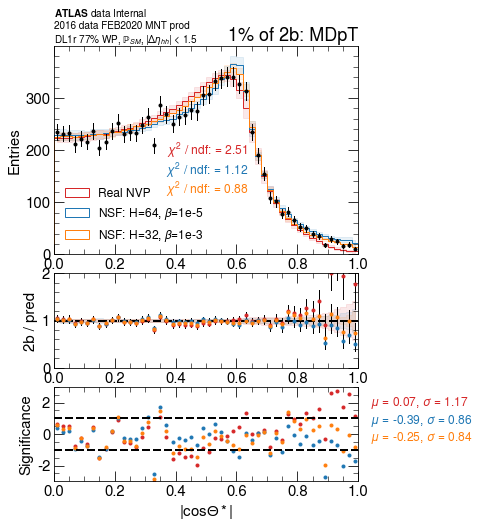

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


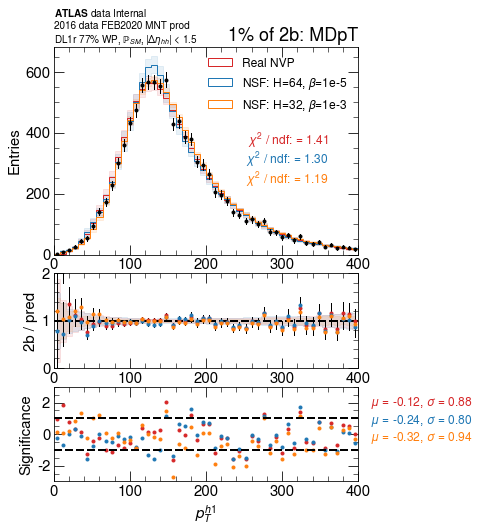

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


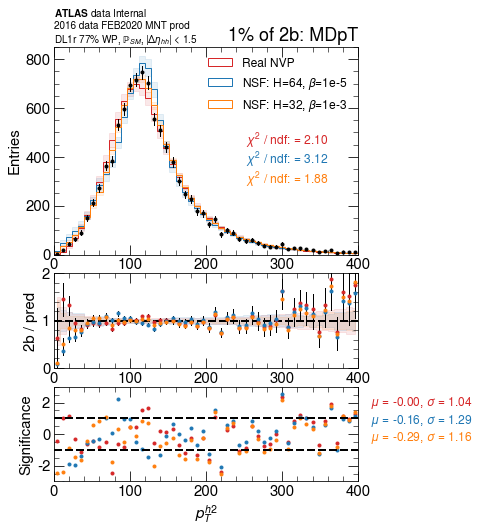

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


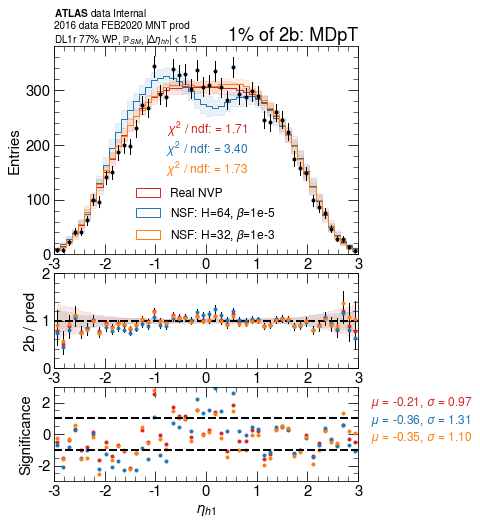

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


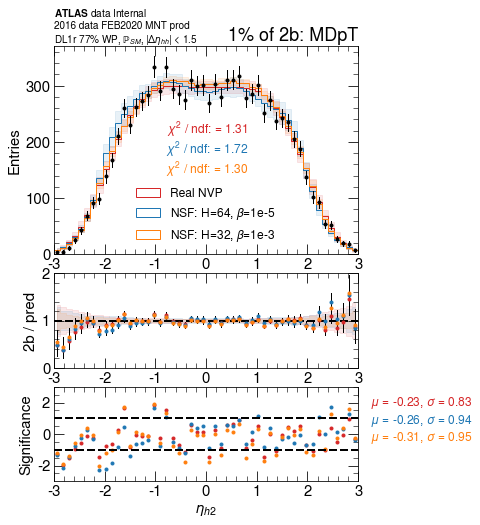

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


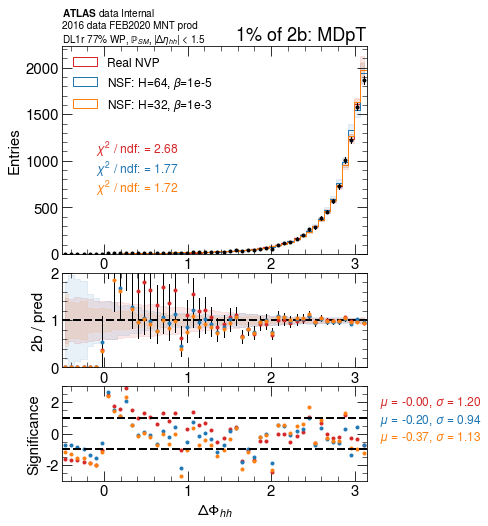

In [82]:
for c,r,xl,wx,wy,ha,va in zip(myVars, myRanges,varLabels,
                              [0.9, 0.9, 0.5, 0.5,0.9,0.9,0.5,0.5,0.1],
                              [0.55,0.55,0.5,0.45,0.5,0.5,0.55,0.55,0.55],
                              ['right','right','center','center','right','right','center','center','left'],
                              ['top','top','bottom','bottom','bottom','bottom','bottom','bottom','top']):

    # Make the figure
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(4,2)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = fig.add_subplot(gs[2,0],sharex=ax1)
    ax3 = fig.add_subplot(gs[3,0],sharex=ax1)
    
    n_2b,e = np.histogram(d_mdpt.df.loc[mask,c],bins,r)
    xx = 0.5 * ( e[1:] + e[:-1] )
    
    # Add text for the chi^2s for these comparisons
    ls,lc = [], []
    zs,zc = [], []
    
    for nom,std,color,l in zip([out[f'{c}_MDpT_mean'],hists[6][f'{c}_mean'],hists[4][f'{c}_mean']],
                               [out[f'{c}_MDpT_std'],hists[6][f'{c}_std'],hists[4][f'{c}_std']],
                               ['C3','C0','C1'],['Real NVP',f'NSF: H=64, {betaStr}=1e-5',f'NSF: H=32, {betaStr}=1e-3']):
        
        ax1.fill_between(xx, nom+std, nom-std, color=color,zorder=0,step='mid',alpha=.1)
        ax2.fill_between(xx, (nom+std)/nom, (nom-std)/nom, color=color,zorder=0,step='mid',alpha=0.1)
        
        ax1.hist(xx, bins,r,color=color,histtype='step',weights=nom,label=l)
        ax2.errorbar(xx,n_2b/nom,np.sqrt(n_2b)/nom,fmt='.',color=color,elinewidth=1,ecolor='k')
        
        X2 = chisquare(n_2b,nom)[0]
        ls.append(f'$\chi^2$ / ndf: = {X2/bins:.2f}')
        lc.append(color)
        
        z = significance(n_2b,nom,std)
        ax3.plot(xx,z,lw=0,marker='.',color=color)
        
        mu,sigma = np.mean(z),np.std(z)
        zs.append(f'$\mu$ = {mu:1.2f}, $\sigma$ = {sigma:1.2f}')
        zc.append(color)
        
    
    # Add some curves and lines which only needs to be done once
    ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',elinewidth=1)
    ax2.plot(r,[1]*2,'k--',lw=2)
    
    ax3.plot(r,[1]*2,'k--',lw=2)
    ax3.plot(r,[-1]*2,'k--',lw=2)
    
    # legends
    ax1.set_ylabel('Entries')
    ax2.set_ylabel('2b / pred')
    ax3.set_ylabel('Significance')
    ax3.set_xlabel(xl)
    
    # ranges
    ax1.set_xlim(r)
    ax2.set_ylim(0,2)
    ax3.set_ylim(-3, 3)
    ax1.legend(fontsize=12)
    
    ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes,fontsize=10)
    ax1.set_title('1% of 2b: MDpT',loc='right')
    
    x = wx*r[1]+ (1-wx)*r[0]
    y = wy*ax1.get_ylim()[1]
    rainbow_text(x,y,ls,lc,yoffset=1,ax=ax1,fontsize=12,ha=ha,va=va)
    rainbow_text(1.03*r[1]+-.03*r[0],2.5,zs,zc,yoffset=1.1,ax=ax3,fontsize=12,ha='left',va='top')
    
    plt.savefig(f'{tmpDir}/{c}_SR_L_10_2_blocks_K_4_lr_0.001_p_0.01.pdf',bbox_inches='tight')
    #break

In [80]:
out.keys()

dict_keys(['m_hh_mean', 'm_hh_std', 'm_hh_MDpT_mean', 'm_hh_MDpT_std', 'm_hh_cor2_mean', 'm_hh_cor2_std', 'm_hh_cor2_MDpT_mean', 'm_hh_cor2_MDpT_std', 'abs_deta_hh_mean', 'abs_deta_hh_std', 'abs_deta_hh_MDpT_mean', 'abs_deta_hh_MDpT_std', 'absCosThetaStar_mean', 'absCosThetaStar_std', 'absCosThetaStar_MDpT_mean', 'absCosThetaStar_MDpT_std', 'pT_h1_mean', 'pT_h1_std', 'pT_h1_MDpT_mean', 'pT_h1_MDpT_std', 'pT_h2_mean', 'pT_h2_std', 'pT_h2_MDpT_mean', 'pT_h2_MDpT_std', 'eta_h1_mean', 'eta_h1_std', 'eta_h1_MDpT_mean', 'eta_h1_MDpT_std', 'eta_h2_mean', 'eta_h2_std', 'eta_h2_MDpT_mean', 'eta_h2_MDpT_std', 'dphi_hh_mean', 'dphi_hh_std', 'dphi_hh_MDpT_mean', 'dphi_hh_MDpT_std'])